# Common import and setup


In [44]:
import os, sys, time, pytest

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import pdfminer

from IPython.display import display

# Make sure we use the local version of camelot if it is here
sys.path.insert(0, os.path.abspath(''))

import camelot
from camelot.core import Table, TableList, TextEdges
from camelot.__version__ import generate_version
from camelot.utils import get_text_objects, text_in_bbox
from camelot.parsers.stream import Stream
from camelot.parsers.hybrid import Hybrid
from camelot.handlers import PDFHandler
from camelot.plotting import draw_pdf
from tests.data import *

testdir = os.path.dirname(os.path.abspath('.'))
testdir = os.path.join(testdir, "camelot/tests/files")

# Set up plots to be large enough for visualization
plt.rcParams["figure.figsize"] = [26, 12]

# To check which library we're using
camelot.__file__


'/Users/francoishuet/Code/camelot/camelot/__init__.py'

In [41]:
kwargs = {}
data = None
# pdf_file = "vertical_header.pdf"
# pdf_file, kwargs, data = "superscript.pdf", {"flag_size": True}, data_stream_flag_size # test_hybrid_flag_size
# pdf_file = "health.pdf"  # test_hybrid
# pdf_file = "clockwise_table_2.pdf"
pdf_file = "tabula/12s0324.pdf" # interesting because contains two separate tables
# pdf_file, kwargs = "tabula/us-007.pdf", {"table_regions": ["320,335,573,505"]} # test_hybrid_table_regions
# pdf_file, kwargs = "detect_vertical_false.pdf", {"strip_text": " ,\n"}  # data_stream_strip_text
# pdf_file, kwargs, data = "tabula/m27.pdf", {"columns": ["72,95,209,327,442,529,566,606,683"], "split_text": True, }, data_stream_split_text  # data_stream_split_text
# pdf_file = "vertical_header.pdf"
# pdf_file = "twotables_2.pdf"
# pdf_file = "camelot-issue-132-multiple-tables.pdf"
# pdf_file, kwargs, data = "edge_tol.pdf", {"edge_tol": 500}, data_stream_edge_tol
# pdf_file, kwargs, data = "edge_tol.pdf", {}, data_stream_edge_tol

filename = os.path.join(testdir, pdf_file)

,0,1,2,3,4,5,6,7,8,9
0,Program. Represents arrests reported (not char...,,,,,,,,,
1,by the FBI. Some persons may be arrested more ...,,,,,,,,,
2,could represent multiple arrests of the same p...,,,,,,,,,
3,,,Total,,,Male,,,Female,
4,Offense charged,,Under 18,18 years,,Under 18,18 years,,Under 18,18 years
5,,Total,years,and over,Total,years,and over,Total,years,and over
6,Total .\n .\n . . . . . .\n . .\n . ....,"11,062 .6","1,540 .0","9,522 .6","8,263 .3","1,071 .6","7,191 .7","2,799 .2",468 .3,"2,330 .9"
7,Violent crime . . . . . . . .\n . .\...,467 .9,69 .1,398 .8,380 .2,56 .5,323 .7,87 .7,12 .6,75 .2
8,Murder and nonnegligent,,,,,,,,,
9,manslaughter . . . . . . . .\n. .\n. .\n. .\n....,10.0,0.9,9.1,9.0,0.9,8.1,1.1,–,1.0


,0,1,2,3
0,Offense charged,Total,Male,Female
1,,Under 18 \n18 years \nTotal\nyears\nand over,Under 18 \n18 years \nTotal\nyears\nand over,Under 18 \n18 years \nTotal\nyears\nand over
2,Total .\n .\n . . . . . .\n . .\n . ....,"11,062 .6\n1,540 .0\n9,522 .6\n467 .9\n69 .1\n...","8,263 .3\n1,071 .6\n7,191 .7\n380 .2\n56 .5\n3...","2,799 .2\n468 .3\n2,330 .9\n87 .7\n12 .6\n75 ...."


,0,1,2,3,4,5,6,7,8,9
0,,,Total,,,Male,,,Female,
1,Offense charged,,Under 18,18 years,,Under 18,18 years,,Under 18,18 years
2,,Total,years,and over,Total,years,and over,Total,years,and over
3,Total .\n .\n . . . . . .\n . .\n . ....,"11,062 .6","1,540 .0","9,522 .6","8,263 .3","1,071 .6","7,191 .7","2,799 .2",468 .3,"2,330 .9"
4,Violent crime . . . . . . . .\n . .\...,467 .9,69 .1,398 .8,380 .2,56 .5,323 .7,87 .7,12 .6,75 .2
5,Murder and nonnegligent,,,,,,,,,
6,manslaughter . . . . . . . .\n. .\n. .\n. .\n....,10.0,0.9,9.1,9.0,0.9,8.1,1.1,–,1.0
7,Forcible rape . . . . . . . .\n. .\n. .\n. .\n...,17.5,2.6,14.9,17.2,2.5,14.7,–,–,–
8,Robbery . . . .\n. .\n. . .\n. . .\n.\n. . .\n...,102.1,25.5,76.6,90.0,22.9,67.1,12.1,2.5,9.5
9,Aggravated assault . . . . . . . .\n. .\n. .\n.,338.4,40.1,298.3,264.0,30.2,233.8,74.4,9.9,64.5


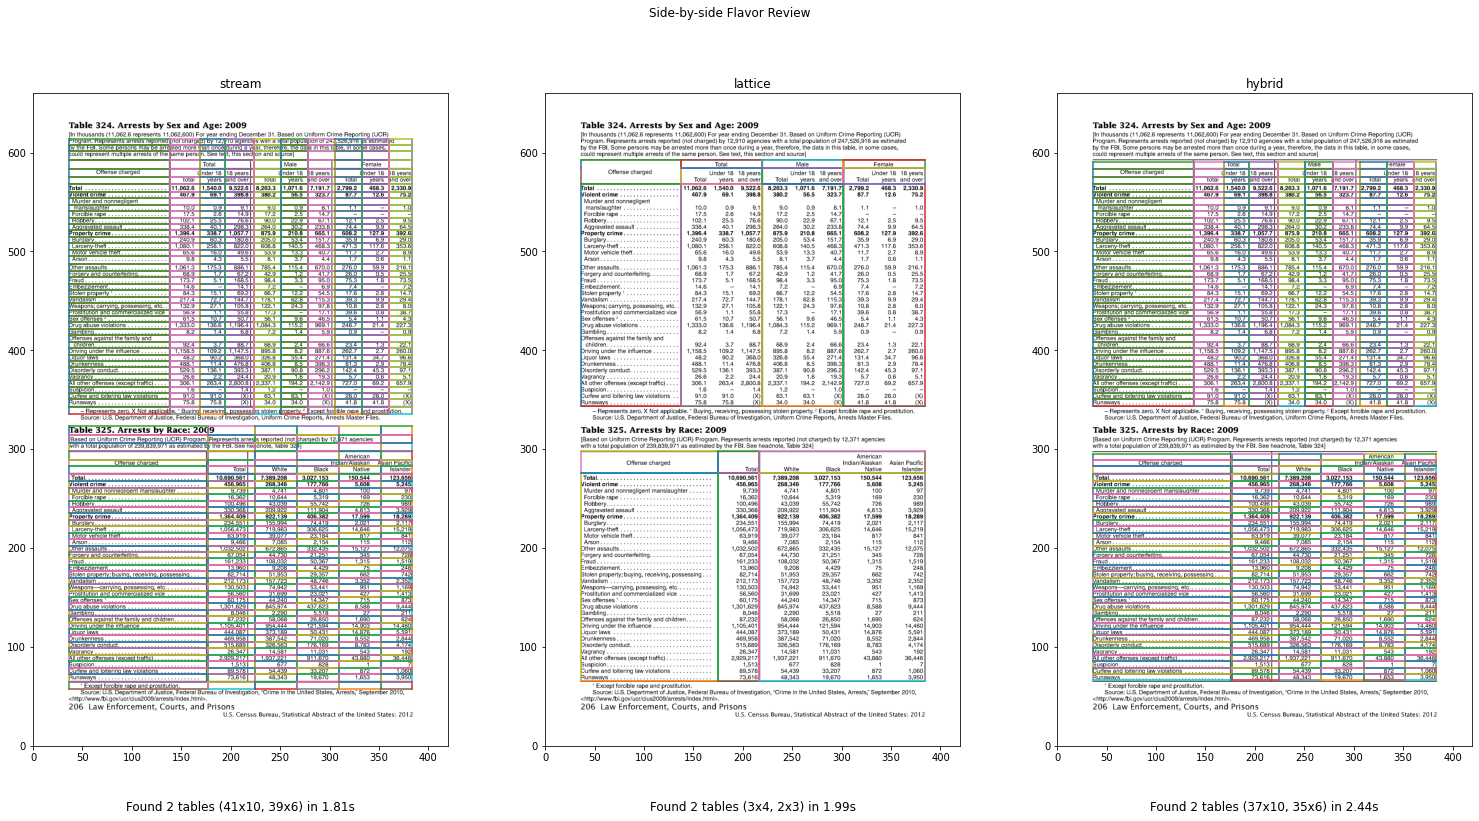

In [45]:

fig, axes = plt.subplots(1, 3)
fig.suptitle('Side-by-side Flavor Review')
tables_list = []
for idx, flavor in enumerate(["stream", "lattice", "hybrid"]):
    timer_before_parse = time.perf_counter()
    tables = camelot.read_pdf(filename, flavor=flavor, debug=True, **kwargs)
    tables_list.append(tables)
    timer_after_parse = time.perf_counter()
    ax = axes[idx]
    if len(tables):
        display(tables[0].df)
    for table in tables:
        fig = camelot.plot(table, kind='grid', ax=ax)
    ax.set_title("{flavor}".format(flavor=flavor))
    tables_dims = ", ".join(
        map(
            lambda table: "{rows}x{cols}".format(
                rows=table.shape[0],
                cols=table.shape[1],
            ), tables
        )
    )
    ax.text(
        0.5,-0.1, 
        "Found {table_num} tables ({tables_dims}) in {parse_time:.2f}s".format(
            table_num=len(tables),
            tables_dims=tables_dims,
            parse_time=timer_after_parse - timer_before_parse,
        ), 
        size=12, ha="center", 
        transform=ax.transAxes
    )
    timer_after_plot = time.perf_counter()
